### Install dependencies

In [1]:
# %pip install xgboost

### Load dependencies

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os, time, sys

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

sys.path.append('../')

from src.functions import *

# Set the local time zone
os.environ['TZ'] = 'America/Montreal'
time.tzset()

gs_uri = 'gs://videotron-ai-bucket/'
dataset_path = gs_uri + 'dataset/'
results_path = gs_uri + 'results/'
figures_path = gs_uri + 'plots/'

### Load data from GCP Bucket

In [3]:
CCT_df, perfo_df = load_dataset(dataset_path)

Dataframe memory usage: 106.62 MB


### Drop columns with to many Nan values

In [4]:
threshold = 0.8 # Drop columns with more than 80% of nan values

print("Dataframe memory usage: %.2f MB" % (CCT_df.memory_usage().sum()/(1024*1024)))

CCT_df = CCT_df.dropna(axis=1, thresh=int(CCT_df.shape[0]*threshold))

Dataframe memory usage: 106.62 MB


### Drop useless columns

In [5]:
drop_list = ['Submitter']

CCT_df = CCT_df.drop(columns=drop_list)

### Cast columns to right types

In [6]:
CCT_df = cast_CCT_features(CCT_df)

Converting Submit_Date
Dataframe memory usage: 71.35 MB


### Group the data by date and create the label for the prediction
* Ticket cnt is the label

In [7]:
groupby = CCT_df.groupby('Submit_Date_day')

agg_df = pd.DataFrame(groupby['status'].count().reset_index().values, columns=['Submit_Date_day', 'Ticket cnt'])
agg_df['Ticket cnt'] = agg_df['Ticket cnt'].astype(int)
agg_df['Submit_Date_day'] = pd.to_datetime(agg_df['Submit_Date_day'])
agg_df['year-month'] = agg_df['Submit_Date_day'].apply(lambda x: str(x.year) + '-'+ str(x.month))
min_dt = agg_df['Submit_Date_day'] .min()

### Plot some charts for analytics

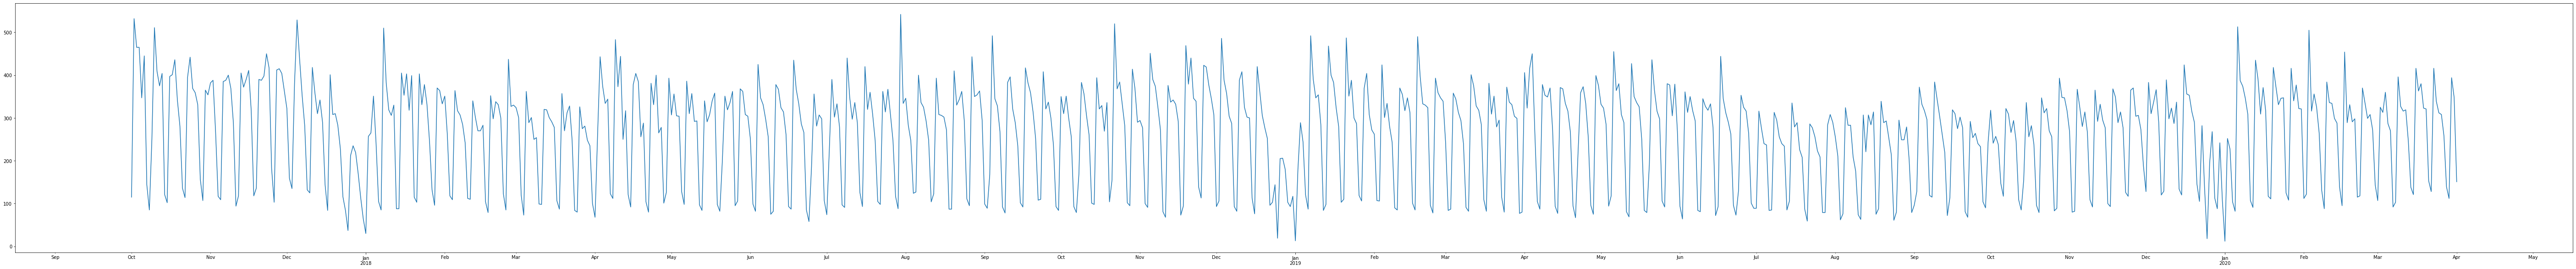

In [8]:
plot_label(agg_df['Submit_Date_day'].values, agg_df['Ticket cnt'].values)

### Feature Engineering for Time Series #1: Date-Related Features

In [9]:
dataset = build_date_related_features(agg_df)

### Feature Engineering for Time Series #2: Event-Related Features
Here is a list of important events that videotron wants to integrate to the machine learning model:
* Black Friday: not a fixed date
* Cyber Monday: not a fixed date (the next monday after a black friday)
* Back to school: not a fixed date. From mid August until mid-september: we chose the last monday of august as a generic date for back to school
* Moving period: from mid-may until mid-july. There is a surge at the end of june. Most of the lease agreement in Quebec start July 1st
* Holidays promotions: from mid-november until the holidays: 2 events: Christmas (December 25th) and first day of the year (January 1st)

In [10]:
dataset = build_event_related_features(dataset)

### Feature Engineering for Time Series #3: Lag Features

We use the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots to determine the lag at which the correlation is significant

* ACF: The ACF plot is a measure of the correlation between the time series and the lagged version of itself
* PACF: The PACF plot is a measure of the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons

More details on ACF and PACF: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

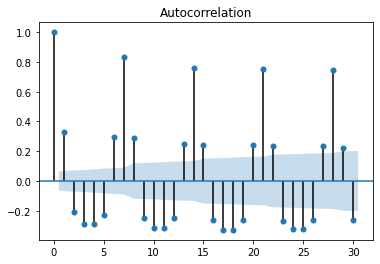

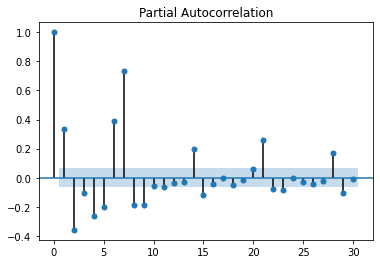

In [11]:
plot_acf(dataset['Ticket cnt'], lags=30)
plot_pacf(dataset['Ticket cnt'], lags=30) 

# Build the lag features
dataset = build_lag_features(dataset)

### Feature Engineering for Time Series #4: Rolling Window Feature


In [12]:
# TBD

### Feature Engineering #5: Weather related features

In [13]:
# weather_df = pd.read_csv(dataset_path + 'daily_weather_montreal.csv', encoding="ISO-8859-1", low_memory=False)
# weather_df['date'] = pd.to_datetime(weather_df['date'].fillna('1900-01-01 00:00:00.000'))
# tmp_df = weather_df.loc[weather_df['date']>=min_dt].reset_index(drop=True).drop(columns=['date','haswx'])
# dataset = pd.concat([dataset, tmp_df], axis=1)

### Feature Engineering #6: STM related features

In [14]:
# TBD

### Feature Engineering #7: Google Trends related features

In [15]:
trends_df = pd.read_csv(dataset_path + 'keyword_trends_dataset.csv', low_memory=False)
trends_df['date'] = pd.to_datetime(trends_df['date'].fillna('1900-01-01 00:00:00.000'))
trends_df = trends_df.loc[trends_df['date']>=min_dt].reset_index(drop=True).drop(columns=['date'])
kw_list = trends_df.columns.values
dataset = pd.concat([dataset, trends_df], axis=1)

### Feature Engineering #8: Feature selection
Based on the following article: https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/

In [16]:
df = dataset.drop(columns=['Submit_Date_day', 'year-month'])

scaler = MinMaxScaler()

scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), columns=df.columns.values)

### Pearson correlation: analysis
* Pearson correlation: https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
* How to interpret Pearson correlation: https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/

Only values with a p-value less or equal than ⍺ (⍺=0.05) and a high pearson-r (above ≈0.40 or below ≈-0.40) score should be kept

feature  pearson_r  abs_pearson_r   p-value
0                        STM   0.012449       0.012449  0.707022
1                    tempête   0.031890       0.031890  0.335526
2                      neige   0.004401       0.004401  0.894291
3                    traffic   0.041735       0.041735  0.207466
4              manifestation  -0.021686       0.021686  0.512606
5                  videotron   0.065842       0.065842  0.046592
6               hydro québec   0.042586       0.042586  0.198338
7   service client videotron   0.053589       0.053589  0.105430
8                  illico tv   0.015715       0.015715  0.635165
9               club illico    0.004336       0.004336  0.895856
10                     helix  -0.050382       0.050382  0.127993
11            videotron plus   0.033099       0.033099  0.317514
12  forfait mobile videotron   0.000693       0.000693  0.983303
13           panne videotron  -0.026003       0.026003  0.432347

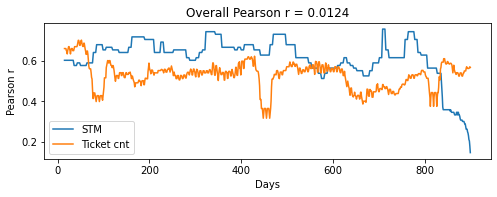

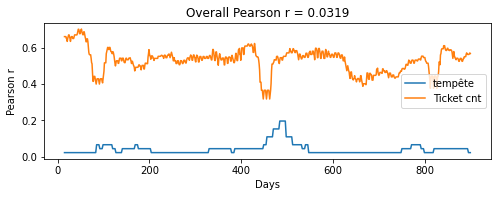

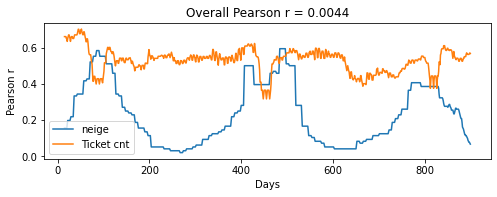

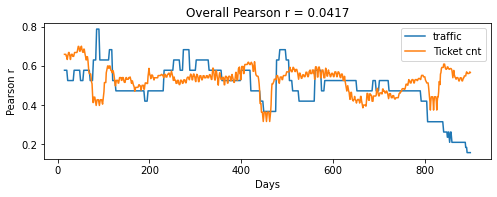

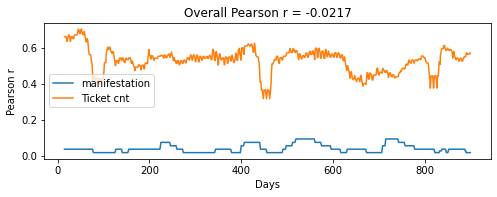

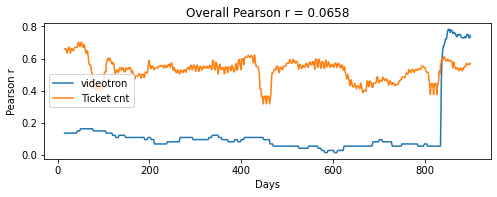

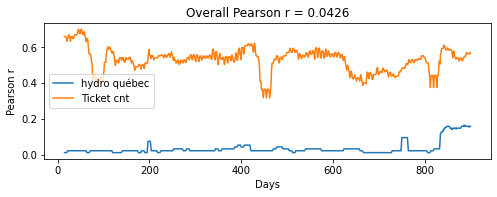

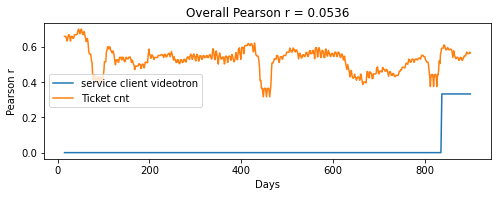

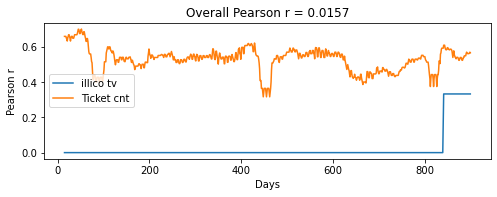

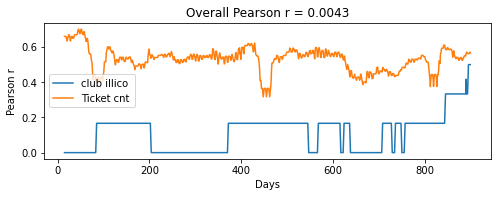

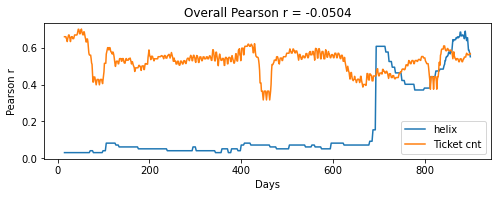

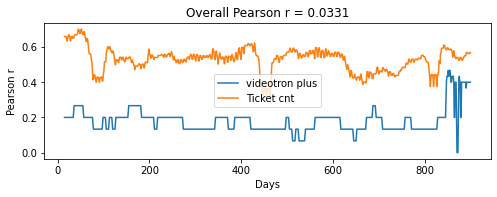

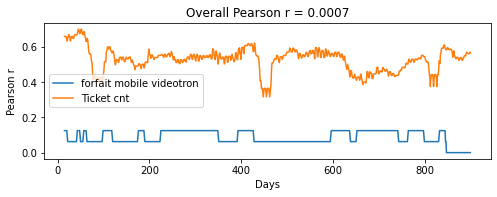

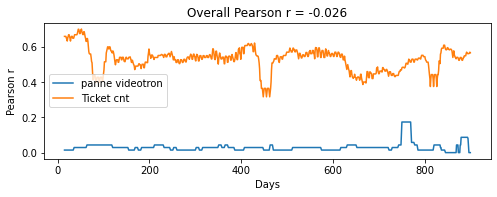

In [17]:
alpha = 0.05
person_r_threshold = 0.40

corr_df = plot_pearson_corr(df, kw_list, plot=True)

# Sort by p-value: most significant feature first
corr_df.sort_values('p-value')

drop_list = corr_df.loc[~((corr_df['abs_pearson_r'] > person_r_threshold) & (corr_df['p-value'] < alpha)), 'feature']
corr_df

### Dump the feature engineered dataset

In [18]:
dataset = dataset.rename(columns={'Submit_Date_day':'date'}).dropna(subset=['date'])

In [19]:
dataset.to_csv(dataset_path + 'videotron_full_dataset.csv', index=False)

## Create a first model to validate the feature engineering

### Day Forward-chaining Nested Cross-Validation
Technic explained here: https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

<img src="https://miro.medium.com/max/1400/1*2-zaRQ-dsv8KWxOlzc8VaA.png" width="70%" height="70%">

In [20]:
n_folds = 26
n_iter = 100
val_length = 1 # in months
test_length = 3 # in months

train_start_dt = dataset['date'].min()

xgb_params = {    
              'objective':'reg:squarederror',
              'random_state': 42,
              'n_jobs': -1
             }

param_dist = {
              'n_estimators': stats.randint(100, 1000),
              'learning_rate': stats.loguniform(0.01, 0.1),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3, 4, 5],
              'random_state': [42]
             }

xgb_rg = xgb.XGBRegressor(**xgb_params)
estimators = []
predictions = []
mse_scores = np.zeros(n_folds)
rmse_scores = np.zeros(n_folds)
r2_scores = np.zeros(n_folds)

Outer loop 26


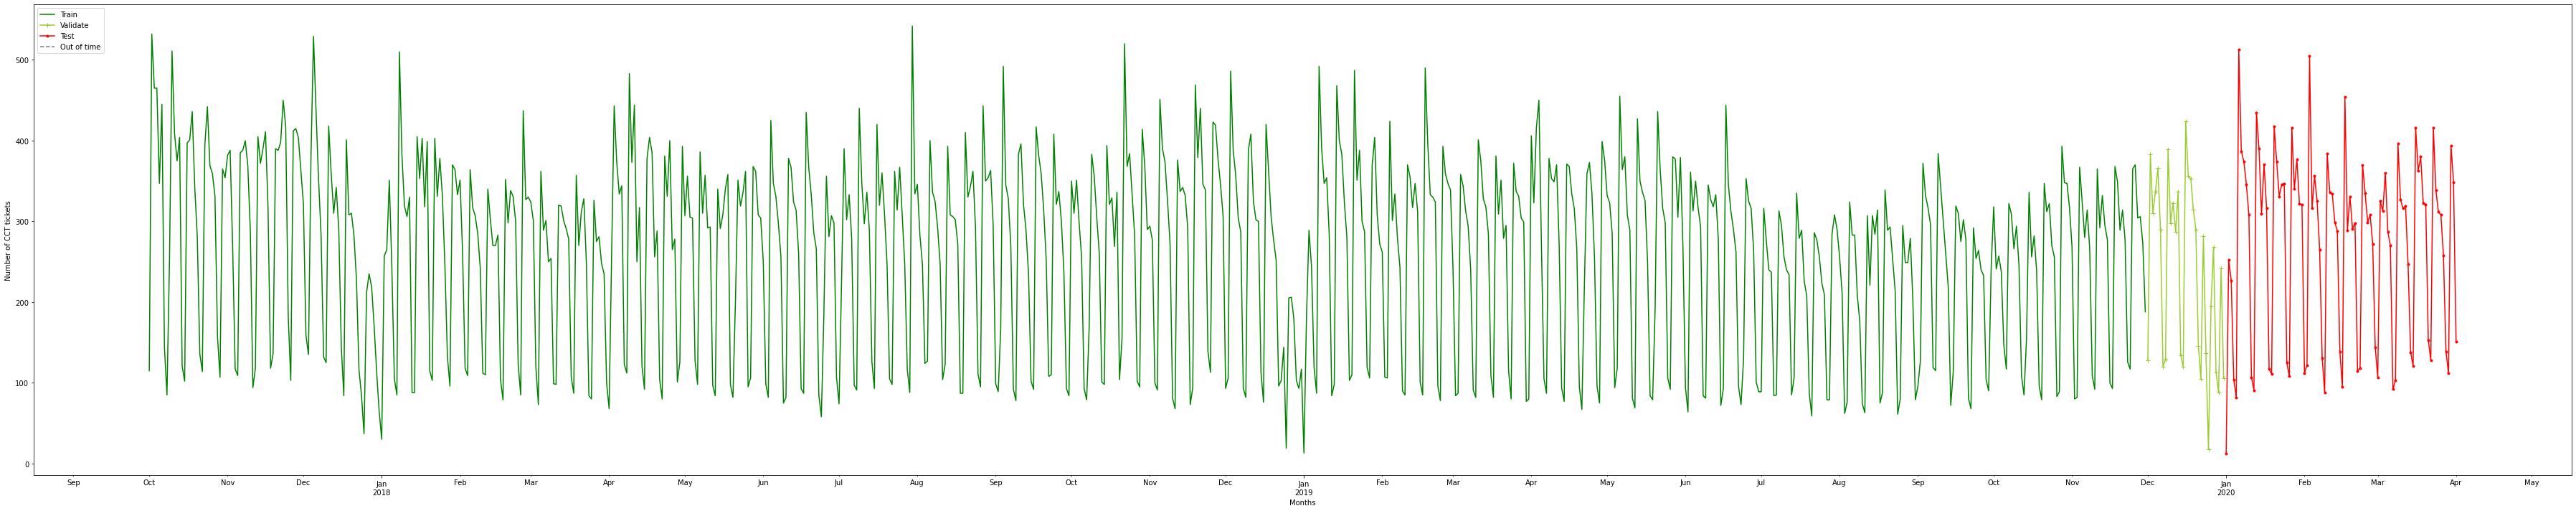

Fitting 1 folds for each of 100 candidates, totalling 100 fits


/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.3s


In [ ]:
for offset_months in range(n_folds, n_folds+1):
    print('Outer loop %d' % offset_months)
    index_val = offset_months-1
    
    X_train, X_val, X_test, X_out_of_time, y_train, y_val, y_test, y_out_of_time, labels = get_train_val_test_dataset(dataset, 
                                                                                                              train_start_dt,
                                                                                                              val_length,
                                                                                                              test_length,
                                                                                                              offset_months)
    
    # Plot the train, validation and test set
    if (offset_months <= n_folds):
        plot_train_val_test(dataset['date'], labels, X_train.index, X_val.index, X_test.index, X_out_of_time.index)
        
    # Do some feature selection here
    corr_df = plot_pearson_corr(dataset.loc[X_train.index], kw_list, plot=False)

    drop_list = corr_df.loc[~((corr_df['abs_pearson_r'] > person_r_threshold) & (corr_df['p-value'] < alpha)), 'feature']
    drop_list = list(drop_list.values)
    
    f_list = X_train.drop(columns=drop_list).columns.values
    
    # Create a new pipeline for a randomized search CV
    regressor = RandomizedSearchCV(xgb_rg, cv=[(X_train[f_list].index,
                                                X_val[f_list].index)],
                                   param_distributions=param_dist, 
                                   n_iter=n_iter, scoring = 'neg_mean_squared_error', 
                                   error_score=0, verbose=3, n_jobs=-1)
    
    # The cross validation will be done only once on the train and validation set
    regressor.fit(X_train[f_list].append(X_val[f_list]), y_train.append(y_val))    
    
    # Get the best estimator
    xgb_rg = regressor.best_estimator_
    
    # Fit a new regressor on the best estimator parameters and evaluate the model
    # The model is fitted on the train & validation dateset then evaluated on the test set
    xgb_rg.fit(X_train[f_list].append(X_val[f_list]), y_train.append(y_val))    
    estimators.append(xgb_rg)
    y_pred = xgb_rg.predict(X_test[f_list])
    predictions.append(y_pred)
    
    mse_scores[index_val] = mean_squared_error(y_test, y_pred)
    rmse_scores[index_val] = mean_squared_error(y_test, y_pred, squared=False)
    r2_scores[index_val] = r2_score(y_test, y_pred)
    print('MSE loop %d: %f' % (offset_months, mse_scores[index_val]))
    print('RMSE loop %d: %f' % (offset_months, rmse_scores[index_val]))
    print('R2 loop %d: %f' % (offset_months, r2_scores[index_val]))

### Retrieve the final model and the final predictions from the nested cross-validation 

In [ ]:
xgb_rg = estimators[-1]
y_pred = predictions[-1]

### Display feature importance
The most important features are showed below

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

xgb.plot_importance(xgb_rg, importance_type='gain', height=0.3, ax=ax,
                    title='XGBoost Regressor Feature Importance', color='green',
                    ylabel='Feature name', xlabel='Feature importance (Gain)')

### Compute the regression's metrics
* RMSE
* MSE
* R<sup>2</sup>

In [ ]:
mse_score = np.mean(mse_scores) 
rmse_score = np.mean(rmse_scores) 
r2 = np.mean(r2_scores) 

print('MSE score on nested cross-validation: %f' % mse_score)
print('RMSE score on nested cross-validation: %f' % rmse_score)
print('R2 score on nested cross-validation: %f' % r2)

print('MSE score of the last model: %f' % mse_scores[-1])
print('RMSE score of the last model: %f' % rmse_scores[-1])
print('R2 score of the last model: %f' % r2_scores[-1])

# We should keep only the last model trained during the nest cross-validation. Save the results of this model
results={'Datetime': dt.datetime.now().strftime('%Y-%m-%d %H:%M'),
         'MSE': mse_score,
         'RMSE': rmse_score,
         'R2': r2_score,
         'model': 'XGBoost Regressor',
         'comments': 'XGBoost Regressor with internal and trends data'}

### Append the metrics to the results file

In [ ]:
results_df = export_results(results, path=results_path)
results_df

### Plot the predicted volume of tickets vs the observation
The prediction is made on the last test dataset

In [ ]:
_, _, _, test_start_dt, test_end_dt = compute_train_val_test_dates(train_start_dt, val_length, test_length, n_folds)

plot_predictions_vs_observations(dataset.loc[X_test.index, 'date'].values, y_test, y_pred, test_start_dt, test_end_dt)

### Predict the volume of tickets for April/May 2020

In [ ]:
xgb_rg = estimators[-1]
y_pred = predictions[-1]